## Action Plan
### Build model by LUNA to train Data Bowl 2017
1. Data Preprocessing on Data Bowl 2017 data
2. Data Preprocessing on LUNA data for **generate Regions of Interest candidates by Segmentation** 
3. Train Model to **generate Regions of Interest candidates by Segmentation** 
4. Data Preprocessing on LUNA data for **Classification of Lung Nodules **
5. Train Model for **Classification of Lung Nodules **
6. Generate and Validate Predictions 
7. Submit predictions to Kaggle

In [1]:
from importlib import reload

import modeltuning_LUNA; reload(modeltuning_LUNA)
from modeltuning_LUNA import *

import utils_LUNA; reload(utils_LUNA)
from utils_LUNA import *

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
luna_path = "../input/LUNA16/"
luna_subset_path = "../input/LUNA16/subset0/"
output_path = "../input/LUNA16/output/"
model_path = "../input/LUNA16/models/"
working_path = output_path
if not os.path.exists(model_path): os.makedirs(model_path)

### Loading and preprocessing train data

In [3]:
imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

In [4]:
imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

In [5]:
imgs_train.shape, imgs_mask_train.shape, imgs_test.shape, imgs_mask_test_true.shape

((269, 512, 512, 1), (269, 512, 512, 1), (67, 512, 512, 1), (67, 512, 512, 1))

image 1


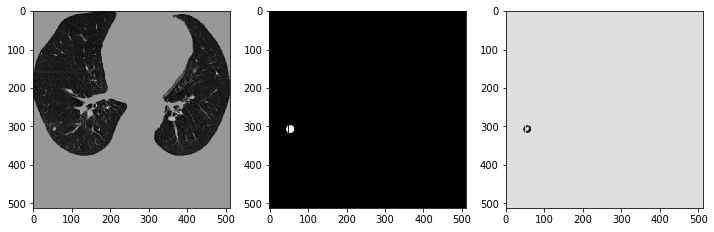

In [12]:
i = 1
print("image %d" % i)
fig,ax = plt.subplots(1,3,figsize=[12,12])
ax[0].imshow(np.squeeze(imgs_train[i]),cmap='gray')
ax[1].imshow(np.squeeze(imgs_mask_train[i]),cmap='gray')
ax[2].imshow(np.squeeze(imgs_train[i])*np.squeeze(imgs_mask_train[i]),cmap='gray')
plt.show()

In [13]:
'''
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std
'''

'\nmean = np.mean(imgs_train)  # mean for data centering\nstd = np.std(imgs_train)  # std for data normalization\n\nimgs_train -= mean  # images should already be standardized, but just in case\nimgs_train /= std\n'

### Creating and compiling model

In [14]:
model = get_unet()

In [15]:
# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint(model_path+'unet.hdf5', monitor='loss', save_best_only=True)

### Fitting model

In [16]:
model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=20, verbose=2, shuffle=True,
              callbacks=[model_checkpoint])

Epoch 1/20
 - 92s - loss: -1.5372e-02 - dice_coef: 0.0154
Epoch 2/20
 - 81s - loss: -2.1651e-02 - dice_coef: 0.0217
Epoch 3/20
 - 81s - loss: -2.5920e-02 - dice_coef: 0.0259
Epoch 4/20
 - 81s - loss: -7.3157e-02 - dice_coef: 0.0732
Epoch 5/20
 - 81s - loss: -9.4392e-02 - dice_coef: 0.0944
Epoch 6/20
 - 81s - loss: -7.0761e-02 - dice_coef: 0.0708
Epoch 7/20
 - 81s - loss: -2.0861e-01 - dice_coef: 0.2086
Epoch 8/20
 - 81s - loss: -2.3566e-01 - dice_coef: 0.2357
Epoch 9/20
 - 81s - loss: -2.9818e-01 - dice_coef: 0.2982
Epoch 10/20
 - 81s - loss: -2.8283e-01 - dice_coef: 0.2828
Epoch 11/20
 - 81s - loss: -3.2488e-01 - dice_coef: 0.3249
Epoch 12/20
 - 81s - loss: -3.6200e-01 - dice_coef: 0.3620
Epoch 13/20
 - 81s - loss: -3.8702e-01 - dice_coef: 0.3870
Epoch 14/20
 - 81s - loss: -3.8719e-01 - dice_coef: 0.3872
Epoch 15/20
 - 81s - loss: -4.0394e-01 - dice_coef: 0.4039
Epoch 16/20
 - 81s - loss: -3.8921e-01 - dice_coef: 0.3892
Epoch 17/20
 - 81s - loss: -4.1109e-01 - dice_coef: 0.4111
Epoch 

In [ ]:
model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=5, verbose=2, shuffle=True,
              callbacks=[model_checkpoint])

Epoch 1/5
 - 80s - loss: -4.6102e-01 - dice_coef: 0.4610
Epoch 2/5


### Load best weights from training session

In [17]:
model.load_weights(model_path+'unet.hdf5')

### Predicting masks on test data

In [18]:
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,512,512,1],dtype=np.float32) # Channels Last
#imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0) #[0] # Channels Last

#np.save('masksTestPredicted.npy', imgs_mask_test)
save_array('masksTestPredicted1.bc', imgs_mask_test)

mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(np.squeeze(imgs_mask_test_true[i]), np.squeeze(imgs_mask_test[i]))
mean/=num_test
print("Mean Dice Coeff : ",mean)

Mean Dice Coeff :  0.2975629580172428
